The code fetches historical stock data for Nestle India (ticker symbol “NESTLEIND.NS”) from Yahoo Finance for the past year using the yfinance library. The tabulate library is then used to display the first few rows of this data in a clear, table-like format with headers and row indices, providing a structured overview of stock metrics like Open, High, Low, Close, Adjusted Close, and Volume for each day. This approach is helpful for console environments where readability of large datasets in tabular form enhances data analysis and debugging.

In [13]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate

# Fetch historical data
nestle_india_data = yf.Ticker("NESTLEIND.NS")
nestle_time_series_data = nestle_india_data.history(period="1y")

# Display the first 5 rows in tabular format
def display_table(data):
    print(tabulate(data.head(), headers='keys', tablefmt='grid', showindex=True))

# Call the display function
display_table(nestle_time_series_data)

data = nestle_time_series_data

+---------------------------+---------+---------+---------+---------+----------+-------------+----------------+
| Date                      |    Open |    High |     Low |   Close |   Volume |   Dividends |   Stock Splits |
+===========================+=========+=========+=========+=========+==========+=============+================+
| 2023-11-08 00:00:00+05:30 | 2419.55 | 2423.89 | 2404.76 | 2410.86 |   363050 |           0 |              0 |
+---------------------------+---------+---------+---------+---------+----------+-------------+----------------+
| 2023-11-09 00:00:00+05:30 | 2417.66 | 2424.11 | 2402.01 | 2405.42 |   422230 |           0 |              0 |
+---------------------------+---------+---------+---------+---------+----------+-------------+----------------+
| 2023-11-10 00:00:00+05:30 | 2405.42 | 2407.68 | 2388.44 | 2396.53 |   283170 |           0 |              0 |
+---------------------------+---------+---------+---------+---------+----------+-------------+----------

# Without KG - only GRU prediction
The code fetches Nestle India’s stock data for the past year using Yahoo Finance, scales it using MinMaxScaler, and trains a GRU model to predict the next 30 days of stock prices based on the past 60 days. The model uses two GRU layers and Dense layers to learn the price trends, and predictions are made iteratively for the next 30 days. The predicted prices are then plotted alongside the historical data in an interactive Plotly chart, with historical prices in blue and predicted prices in red, helping to visualize future price trends.



In [29]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the data
nestle_india_data = yf.Ticker("NESTLEIND.NS")
data = nestle_india_data.history(period="1y")
data = data[['Close']]

# Step 2: Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Step 3: Create training and test datasets
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 4: Build the GRU Model
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Step 5: Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=1, batch_size=16, verbose=1)

# Step 6: Predict the next 30 days
last_60_days = data_scaled[-time_step:].reshape(1, time_step, 1)
predicted_prices = []

for _ in range(30):
    # Predict the next day's price
    prediction = model.predict(last_60_days, verbose=0)
    predicted_prices.append(prediction[0, 0])

    # Update the prediction input by removing the oldest value and appending the new prediction
    last_60_days = np.concatenate((last_60_days[:, 1:, :], prediction[:, None, :]), axis=1)

# Transforming back to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Calculate evaluation metrics
y_true = data[-len(predicted_prices):]['Close']
y_pred = predicted_prices.flatten()
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# Step 7: Plot the results
import plotly.graph_objects as go
from datetime import timedelta

# Define future dates for the predictions
future_dates = [data.index[-1] + timedelta(days=i) for i in range(1, 31)]

# Create the figure with plotly
fig = go.Figure()

# Add historical stock price trace
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Close'],
    mode='lines+markers',
    name='Historical Prices',
    line=dict(color='blue'),
    hovertemplate='Date: %{x}<br>Stock Price: %{y}<extra></extra>'
))

# Add predicted stock price trace
fig.add_trace(go.Scatter(
    x=future_dates,
    y=predicted_prices.flatten(),
    mode='lines+markers',
    name='Predicted Prices for Next 30 Days',
    line=dict(color='red', dash='dash'),
    hovertemplate='Date: %{x}<br>Predicted Price: %{y}<extra></extra>'
))

# Update layout for a cleaner look
fig.update_layout(
    title='Nestle India Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    legend_title='Stock Data',
    template='plotly_dark',
    hovermode='x'
)

# Show the interactive plot
fig.show()
import numpy as np

# Convert the predictions to a NumPy array
predicted_array = np.array(predicted_prices.flatten())

# Save the array to a .npy file with the correct name
np.save("/content/nestle_stock_predictions1.npy", predicted_array)

print("Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.1103
Mean Squared Error (MSE): 66297.2213
R-squared (R2) Score: -1.6596


Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'


# Without KG - only LSTM prediction

In [36]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the data
nestle_india_data = yf.Ticker("NESTLEIND.NS")
data = nestle_india_data.history(period="1y")
data = data[['Close']]

# Step 2: Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Step 3: Create training and test datasets
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 4: Build the GRU Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Step 5: Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=1, batch_size=16, verbose=1)

# Step 6: Predict the next 30 days
last_60_days = data_scaled[-time_step:].reshape(1, time_step, 1)
predicted_prices = []

for _ in range(30):
    # Predict the next day's price
    prediction = model.predict(last_60_days, verbose=0)
    predicted_prices.append(prediction[0, 0])

    # Update the prediction input by removing the oldest value and appending the new prediction
    last_60_days = np.concatenate((last_60_days[:, 1:, :], prediction[:, None, :]), axis=1)

# Transforming back to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Calculate evaluation metrics
y_true = data[-len(predicted_prices):]['Close']
y_pred = predicted_prices.flatten()
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# Step 7: Plot the results
import plotly.graph_objects as go
from datetime import timedelta

# Define future dates for the predictions
future_dates = [data.index[-1] + timedelta(days=i) for i in range(1, 31)]

# Create the figure with plotly
fig = go.Figure()

# Add historical stock price trace
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Close'],
    mode='lines+markers',
    name='Historical Prices',
    line=dict(color='blue'),
    hovertemplate='Date: %{x}<br>Stock Price: %{y}<extra></extra>'
))

# Add predicted stock price trace
fig.add_trace(go.Scatter(
    x=future_dates,
    y=predicted_prices.flatten(),
    mode='lines+markers',
    name='Predicted Prices for Next 30 Days',
    line=dict(color='red', dash='dash'),
    hovertemplate='Date: %{x}<br>Predicted Price: %{y}<extra></extra>'
))

# Update layout for a cleaner look
fig.update_layout(
    title='Nestle India Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    legend_title='Stock Data',
    template='plotly_dark',
    hovermode='x'
)

# Show the interactive plot
fig.show()
import numpy as np

# Convert the predictions to a NumPy array
predicted_array = np.array(predicted_prices.flatten())

# Save the array to a .npy file with the correct name
np.save("/content/nestle_stock_predictions2.npy", predicted_array)

print("Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1084
Mean Squared Error (MSE): 34064.1660
R-squared (R2) Score: -0.3665


Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'


In [3]:
import yfinance as yf
from textblob import TextBlob
import pandas as pd

# Get the news data for Nestle India
nestle_india = yf.Ticker("TATAMOTORS.NS")
news = nestle_india.news

# Convert news data to a DataFrame for easier manipulation
news_df = pd.DataFrame(news)

# Display the first few news headlines to verify data
print(news_df[['title', 'publisher', 'link']].head())

                                               title  \
0           Marcus & Millichap: Q3 Earnings Snapshot   
1  Global Hydrogen Pipelines Length and Capital E...   
2  Tetragon Financial Group Limited Dividend Info...   
3  This Week in Finance News: 10 Stories You Need...   
4  e.l.f. Beauty Second Quarter 2025 Earnings: Be...   

                  publisher                                               link  
0  Associated Press Finance  https://finance.yahoo.com/news/marcus-millicha...  
1             GlobeNewswire  https://finance.yahoo.com/news/global-hydrogen...  
2               PR Newswire  https://finance.yahoo.com/news/tetragon-financ...  
3               PR Newswire  https://finance.yahoo.com/news/week-finance-ne...  
4           Simply Wall St.  https://finance.yahoo.com/news/e-l-f-beauty-se...  


# EVENT DETECTION

The function analyze_news_sentiment processes news article titles to analyze their sentiment and predict market events based on sentiment momentum. It first calculates a sentiment score for each title using the TextBlob library, which outputs a polarity value indicating the sentiment of the text (positive, neutral, or negative). Next, it calculates sentiment momentum by measuring the change in sentiment scores between consecutive articles. Based on these changes, the function classifies the predicted market event as “bullish,” “bearish,” or “neutral.” A “bullish” prediction is made when the sentiment is rising significantly and is positive, while a “bearish” prediction occurs when sentiment is falling and negative. If the sentiment change is minimal, the event is classified as “neutral.” This provides a predictive view of market sentiment based on the flow of news articles.

By adding the sentiment, sentiment momentum, and event prediction columns to the DataFrame, the function enriches the dataset with useful features for further analysis or forecasting, potentially helping investors or analysts understand the market sentiment trends and anticipate movements based on news sentiment.

In [4]:
# Adding a sentiment score column to the DataFrame
news_df['sentiment'] = news_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

# # Display the DataFrame with sentiment scores
# print(news_df[['title', 'sentiment', 'publisher', 'link']])



import pandas as pd
from textblob import TextBlob

def analyze_news_sentiment(news_df):
    """
    Analyze the sentiment of news article titles and predict the overall market event based on sentiment momentum.

    Parameters:
    news_df (pandas.DataFrame): DataFrame containing news article data, including 'title' column.

    Returns:
    pandas.DataFrame: Original DataFrame with added 'sentiment', 'sentiment_momentum', and 'event_prediction' columns.
    """
    # Add sentiment score column
    news_df['sentiment'] = news_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

    # Calculate sentiment momentum
    news_df['sentiment_momentum'] = news_df['sentiment'].diff()

    # Determine event prediction
    news_df['event_prediction'] = news_df.apply(lambda row:
                                               'bullish' if row['sentiment_momentum'] > 0.1 and row['sentiment'] > 0 else
                                               'bearish' if row['sentiment_momentum'] < -0.1 and row['sentiment'] < 0 else
                                               'neutral', axis=1)

    return news_df

print(analyze_news_sentiment(news_df))


                                   uuid  \
0  ea7ab8df-cdb2-3998-8370-5c77f4eb1566   
1  71069c34-0cc2-3993-a534-eb6de003489d   
2  a1f72ab1-44ed-3b66-adbf-4a27fc6b528d   
3  e4cdd6aa-6dec-37cd-9920-23a9a286c3c4   
4  6a14f3df-5390-3509-a4c2-dcf9b28b9d4f   
5  24754baf-2771-31b1-b8eb-44c4d2c0ca9c   
6  2be62bd8-121a-31c5-a7e6-53cd1648fcf3   
7  bd2a4dcf-016e-3580-b421-772993bc3b98   

                                               title  \
0           Marcus & Millichap: Q3 Earnings Snapshot   
1  Global Hydrogen Pipelines Length and Capital E...   
2  Tetragon Financial Group Limited Dividend Info...   
3  This Week in Finance News: 10 Stories You Need...   
4  e.l.f. Beauty Second Quarter 2025 Earnings: Be...   
5  Oddity Tech Third Quarter 2024 Earnings: Beats...   
6  Abdominal Aortic Stent Grafts Pipeline Researc...   
7  Redwire Third Quarter 2024 Earnings: Misses Ex...   

                  publisher  \
0  Associated Press Finance   
1             GlobeNewswire   
2             

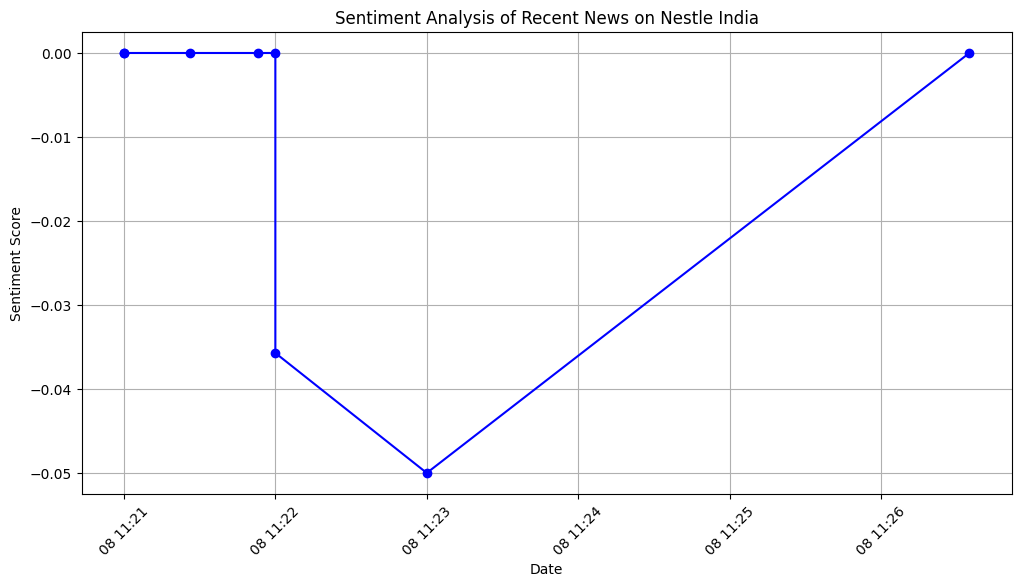

In [5]:
import matplotlib.pyplot as plt

# Convert the 'providerPublishTime' (in Unix timestamp) to a datetime format for plotting
news_df['date'] = pd.to_datetime(news_df['providerPublishTime'], unit='s')

# Plot sentiment over time
plt.figure(figsize=(12, 6))
plt.plot(news_df['date'], news_df['sentiment'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of Recent News on Nestle India')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [6]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.3 MB/s eta 0:00:00


#Knowledge graph representation

 This code uses yfinance to fetch news articles related to Nestle India and performs sentiment analysis on the article titles using TextBlob. It then creates a knowledge graph using networkx, where nodes represent entities such as the company (“Nestle”), publishers, topics, and articles. Relationships between these nodes are established, such as “published by” for publishers and “mentions” for articles related to Nestle. The edges are color-coded based on the sentiment of the article, with green indicating positive sentiment, red for negative, and gray for neutral.

The graph is visualized using matplotlib, where nodes are colored according to their type (e.g., publishers in blue, topics in orange) and the sentiment of the articles influences node colors. The graph provides an overview of how Nestle is mentioned in the news, the sentiment associated with these mentions, and the related topics, offering a simple yet insightful representation of news sentiment around the company.

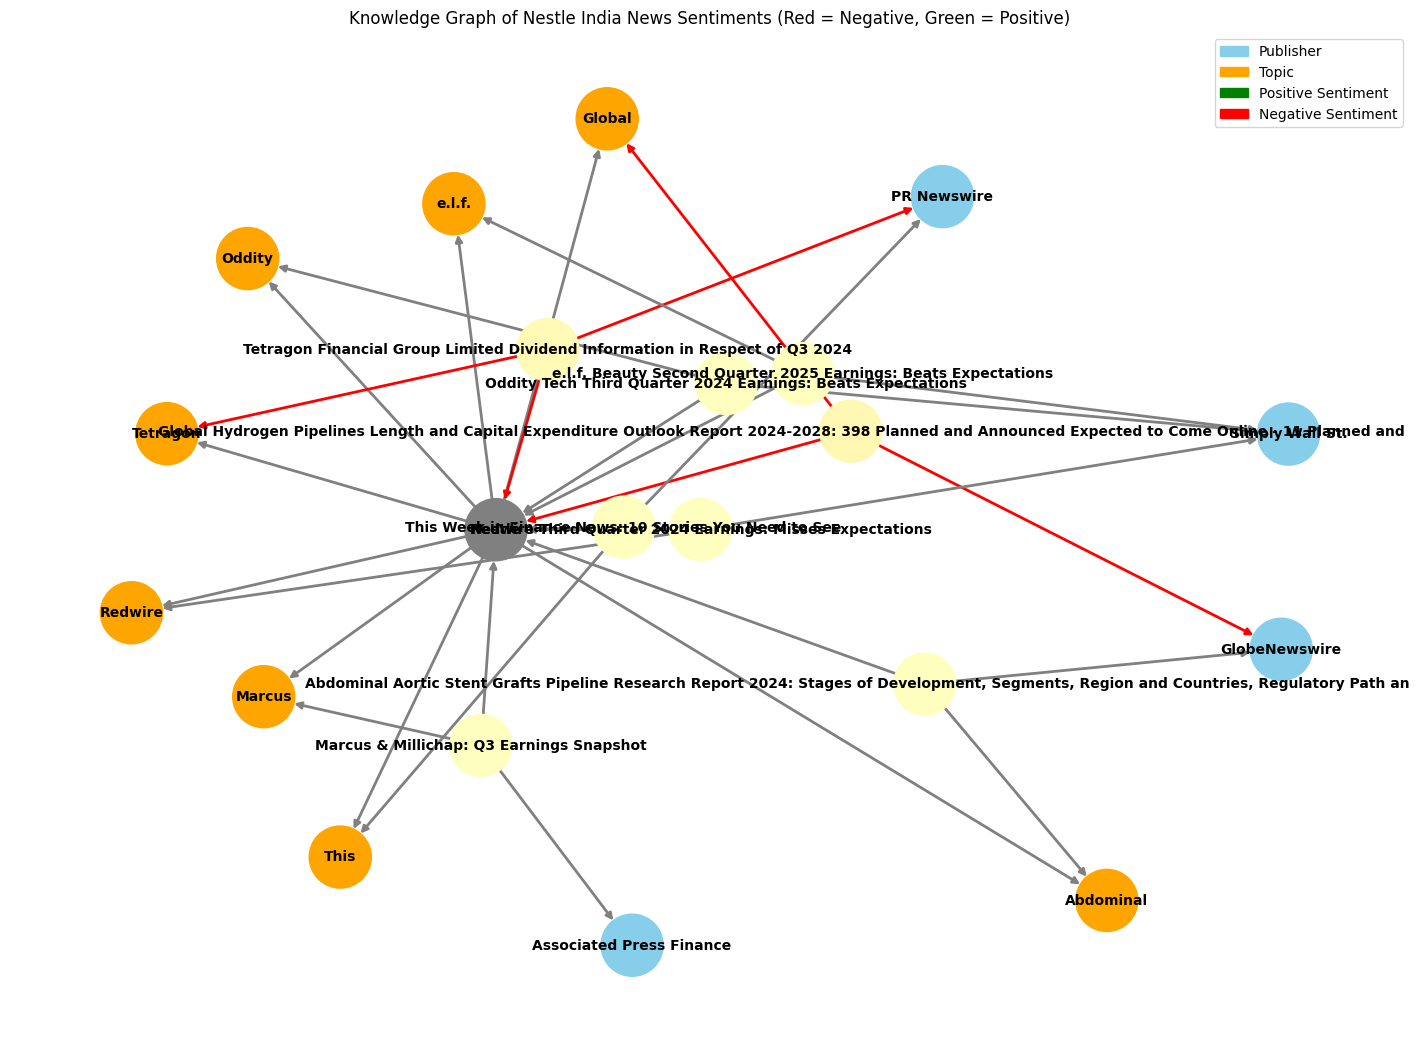

In [7]:
import yfinance as yf
from textblob import TextBlob
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Fetch news data for Nestle India
nestle_india = yf.Ticker("NESTLEIND.NS")
news = nestle_india.news

# Convert news data to DataFrame for easier manipulation
news_df = pd.DataFrame(news)

# Step 2: Perform Sentiment Analysis on headlines
news_df['sentiment'] = news_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

# Step 3: Extract topics from headlines (basic keyword extraction)
news_df['topic'] = news_df['title'].apply(lambda x: x.split()[0] if x else "General")

# Step 4: Create a Knowledge Graph
G = nx.DiGraph()

# Add the main entity node
G.add_node("Nestle", type="Company")

# Add nodes and edges for each article
for _, row in news_df.iterrows():
    article_title = row['title']
    publisher = row['publisher']
    sentiment = row['sentiment']
    topic = row['topic']

    # Add nodes with sentiment
    G.add_node(article_title, type="Article", sentiment=sentiment)
    G.add_node(publisher, type="Publisher")
    G.add_node(topic, type="Topic")

    # Add edges with sentiment-related colors
    edge_color = "green" if sentiment > 0 else "red" if sentiment < 0 else "gray"
    G.add_edge(article_title, publisher, relationship="published by", color=edge_color)
    G.add_edge(article_title, "Nestle", relationship="mentions", color=edge_color)
    G.add_edge(article_title, topic, relationship="related to", color=edge_color)
    G.add_edge("Nestle", topic, relationship="associated topic", color="gray")  # No sentiment on main entity-topic link

# Step 5: Visualize the Knowledge Graph with Sentiment-Based Edge Colors
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)  # Layout for clearer graph

# Set node colors based on sentiment
node_colors = []
for node in G:
    if G.nodes[node]['type'] == "Publisher":
        node_colors.append("skyblue")
    elif G.nodes[node]['type'] == "Topic":
        node_colors.append("orange")
    elif G.nodes[node]['type'] == "Article":
        sentiment = G.nodes[node].get('sentiment', 0)
        # Color: green for positive, red for negative, with gradation
        color = plt.cm.RdYlGn((sentiment + 1) / 2)  # Normalizes sentiment to [0, 1] for colormap
        node_colors.append(color)
    else:
        node_colors.append("gray")  # Default color for main entity

# Extract edge colors from graph attributes
edge_colors = [G[u][v]['color'] for u, v in G.edges()]

# Draw graph with customized colors
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, edge_color=edge_colors,
        font_size=10, font_weight='bold', width=2, arrows=True)

# Custom legend for node types and sentiment
publisher_patch = mpatches.Patch(color="skyblue", label="Publisher")
topic_patch = mpatches.Patch(color="orange", label="Topic")
positive_patch = mpatches.Patch(color="green", label="Positive Sentiment")
negative_patch = mpatches.Patch(color="red", label="Negative Sentiment")
plt.legend(handles=[publisher_patch, topic_patch, positive_patch, negative_patch])

plt.title("Knowledge Graph of Nestle India News Sentiments (Red = Negative, Green = Positive)")
plt.show()

In [8]:
pip install mplcursors

#INTEGRATION OF MODELS
The model integrates both time-series stock price data and sentiment information derived from a dynamic knowledge graph. The core components of this integration involve two key inputs: historical stock prices and sentiment scores derived from news articles.

For the time-series data, a GRU (Gated Recurrent Unit) network is used to capture the temporal dependencies in the stock prices over the past 60 days. This component processes the stock data to understand its trend patterns. Meanwhile, the sentiment data, derived from the news headlines, is passed through a Dense layer to extract relevant features. These features are then combined with the GRU output using a Concatenate layer. This concatenated representation integrates the temporal patterns of the stock price with the sentiment analysis from news articles, allowing the model to leverage both sources of information for stock price prediction.

The final output layer predicts the stock price, and the model is trained to minimize the mean squared error. This dual-input approach enhances the model’s ability to incorporate external news sentiment into stock price forecasting, thus creating a more dynamic and contextually aware prediction model.

74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.0642


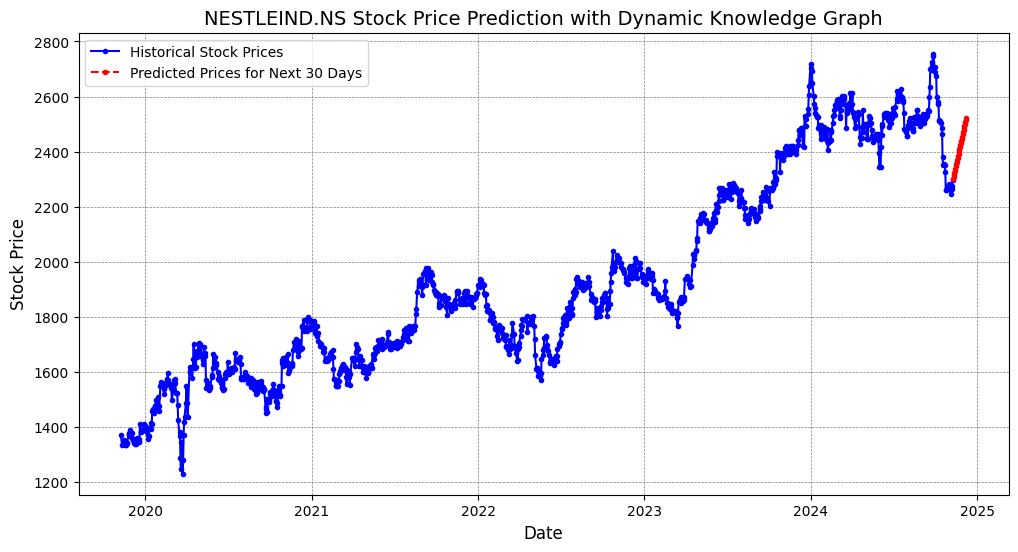

In [9]:
import yfinance as yf
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Concatenate, Input
import networkx as nx  # For creating the knowledge graph
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Fetch Stock Data and News Data
ticker_symbol = "NESTLEIND.NS"
stock_data = yf.Ticker(ticker_symbol).history(period="5y")['Close']
news_data = yf.Ticker(ticker_symbol).news

# Convert news to DataFrame
news_df = pd.DataFrame(news_data)

# Step 2: Preprocess News Data for Sentiment Analysis
if 'published' not in news_df.columns:
    news_df['published'] = pd.to_datetime(news_df['providerPublishTime'], errors='coerce')

news_df['published'] = pd.to_datetime(news_df['published']).dt.tz_localize('Asia/Kolkata')
news_df['sentiment'] = news_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

# Scale sentiment to match stock data
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
news_df['sentiment_scaled'] = scaler_sentiment.fit_transform(news_df[['sentiment']].fillna(0))

# Step 3: Build Dynamic Knowledge Graph with Sentiment Information
def build_dynamic_knowledge_graph(news_df):
    G = nx.Graph()
    for i, row in news_df.iterrows():
        company_node = row.get('title', '').split()[0]  # Extract a topic (company name or keyword)
        sentiment = row['sentiment_scaled']

        # Add company node with sentiment as an attribute
        if not G.has_node(company_node):
            G.add_node(company_node, sentiment=sentiment)
        else:
            # Average the sentiment if the node already exists
            G.nodes[company_node]['sentiment'] = (G.nodes[company_node]['sentiment'] + sentiment) / 2

        # Example: Add an edge to a "Market" node indicating sentiment connection
        G.add_edge(company_node, 'Market', weight=sentiment)

    return G

# Build the graph
knowledge_graph = build_dynamic_knowledge_graph(news_df)

# Extract sentiment from the knowledge graph
# Ensuring sentiment exists in node attributes
topic_sentiments = {node: G.nodes[node].get('sentiment', 0) for node in G.nodes}

# Convert topic_sentiments to a consistent feature vector for the model
topic_features = np.array(list(topic_sentiments.values())).reshape(1, -1)
topic_features = np.repeat(topic_features, len(stock_data), axis=0)  # Repeat for each time step

# Step 4: Prepare Stock Price Data and Sentiment Data
stock_data.index = stock_data.index.tz_convert('Asia/Kolkata')
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

# Aggregate sentiment data per day and align with stock dates
sentiment_data = news_df.groupby(news_df['published'].dt.date)['sentiment_scaled'].mean()
sentiment_data.index = pd.to_datetime(sentiment_data.index).tz_localize('Asia/Kolkata')
sentiment_data = sentiment_data.reindex(stock_data.index, method='ffill').fillna(0)

# Combine stock and sentiment data
data = pd.DataFrame({
    'stock_price': stock_data_scaled.squeeze(),
    'sentiment': sentiment_data.values
})

# Step 5: Create Dataset for GRU Model
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, 0])  # Predict stock price
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 days for prediction
dataset = data.values
X, y = create_dataset(dataset, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Step 6: Define Model with Dynamic Knowledge Graph Features
input_time_series = Input(shape=(X.shape[1], X.shape[2]))
input_knowledge_graph = Input(shape=(topic_features.shape[1],))

# GRU Layers for time series
x1 = GRU(units=50, return_sequences=True)(input_time_series)
x1 = GRU(units=50, return_sequences=False)(x1)

# Knowledge Graph Dense Layer
x2 = Dense(units=25, activation='relu')(input_knowledge_graph)

# Concatenate GRU output with knowledge graph features
x = Concatenate()([x1, x2])

# Output layer to predict stock price
output = Dense(units=1)(x)

# Build and compile model
model = Model(inputs=[input_time_series, input_knowledge_graph], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare topic_features for training
topic_features_train = topic_features[:X.shape[0]]

# Train the model
model.fit([X, topic_features_train], y, epochs=1, batch_size=16, verbose=1)

# Step 7: Predict Next 30 Days
last_60_days = dataset[-time_step:].reshape(1, time_step, 2)
predicted_prices = []

for _ in range(30):
    prediction = model.predict([last_60_days, topic_features_train[-1].reshape(1, -1)], verbose=0)
    predicted_prices.append(prediction[0, 0])

    # Update input with prediction and repeat last sentiment
    new_input = np.array([[prediction[0, 0], last_60_days[0, -1, 1]]])
    last_60_days = np.concatenate((last_60_days[:, 1:, :], new_input[:, None, :]), axis=1)

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Plot Predictions
import matplotlib.pyplot as plt
from datetime import timedelta

# Define future dates for the predictions
future_dates = [stock_data.index[-1] + timedelta(days=i) for i in range(1, 31)]

# Update figure style and colors for a white background
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data.values, label='Historical Stock Prices', color='blue', marker='o', markersize=3)
plt.plot(future_dates, predicted_prices, label='Predicted Prices for Next 30 Days', color='red', linestyle='--', marker='o', markersize=3)

# Customize labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.title(f'{ticker_symbol} Stock Price Prediction with Dynamic Knowledge Graph', fontsize=14)

# Display legend with updated settings
plt.legend(loc='best', fontsize=10)

# Set a white background style
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('white')

# Show plot
plt.show()

# SAME MODEL FOR 1 YEAR TIME SERIES DATA

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.1326
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0256
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0165
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0111
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0108
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0076
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0071
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0063
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0058
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0055


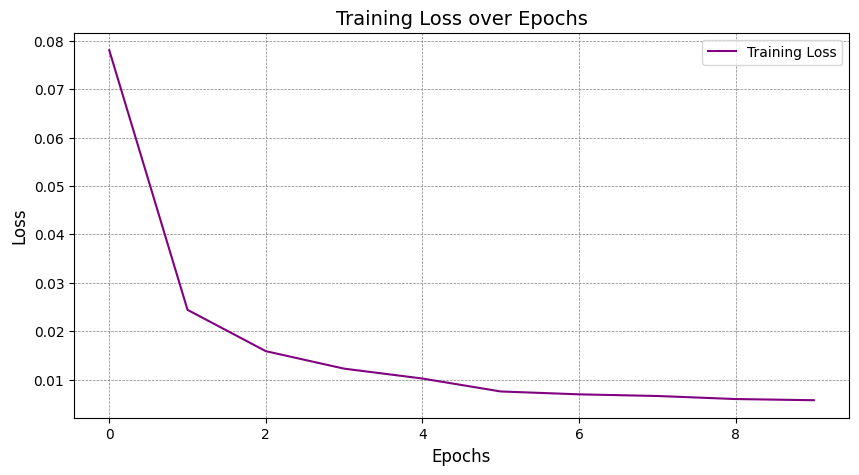

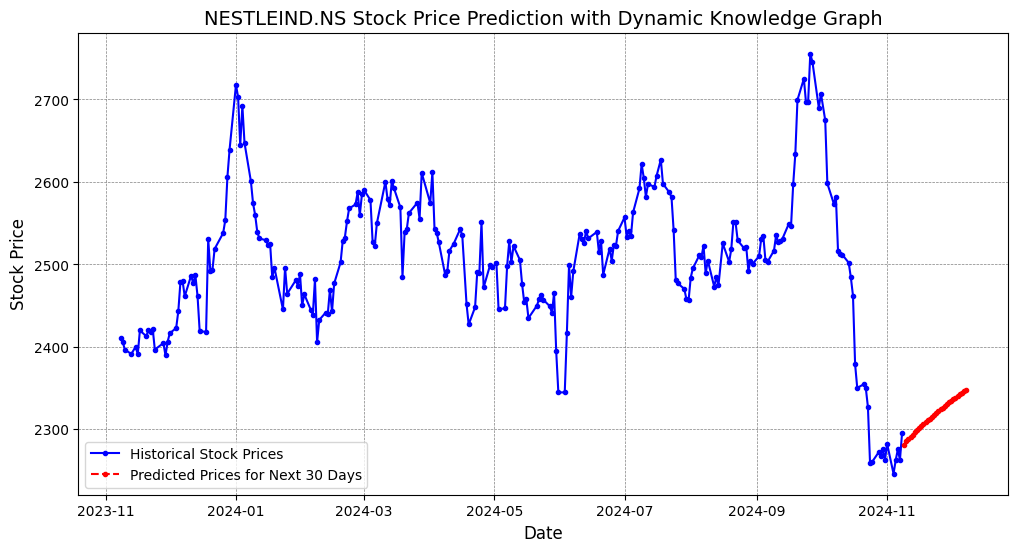

In [10]:
import yfinance as yf
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Concatenate, Input
import networkx as nx  # For creating the knowledge graph
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Fetch Stock Data and News Data
ticker_symbol = "NESTLEIND.NS"
stock_data = yf.Ticker(ticker_symbol).history(period="1y")['Close']
news_data = yf.Ticker(ticker_symbol).news

# Convert news to DataFrame
news_df = pd.DataFrame(news_data)

# Step 2: Preprocess News Data for Sentiment Analysis
if 'published' not in news_df.columns:
    news_df['published'] = pd.to_datetime(news_df['providerPublishTime'], errors='coerce')

news_df['published'] = pd.to_datetime(news_df['published']).dt.tz_localize('Asia/Kolkata')
news_df['sentiment'] = news_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

# Scale sentiment to match stock data
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
news_df['sentiment_scaled'] = scaler_sentiment.fit_transform(news_df[['sentiment']].fillna(0))

# Step 3: Build Dynamic Knowledge Graph with Sentiment Information
def build_dynamic_knowledge_graph(news_df):
    G = nx.Graph()
    for i, row in news_df.iterrows():
        company_node = row.get('title', '').split()[0]  # Extract a topic (company name or keyword)
        sentiment = row['sentiment_scaled']

        # Add company node with sentiment as an attribute
        if not G.has_node(company_node):
            G.add_node(company_node, sentiment=sentiment)
        else:
            # Average the sentiment if the node already exists
            G.nodes[company_node]['sentiment'] = (G.nodes[company_node]['sentiment'] + sentiment) / 2

        # Example: Add an edge to a "Market" node indicating sentiment connection
        G.add_edge(company_node, 'Market', weight=sentiment)

    return G

# Build the graph
knowledge_graph = build_dynamic_knowledge_graph(news_df)

# Extract sentiment from the knowledge graph
# Ensuring sentiment exists in node attributes
topic_sentiments = {node: G.nodes[node].get('sentiment', 0) for node in G.nodes}

# Convert topic_sentiments to a consistent feature vector for the model
topic_features = np.array(list(topic_sentiments.values())).reshape(1, -1)
topic_features = np.repeat(topic_features, len(stock_data), axis=0)  # Repeat for each time step

# Step 4: Prepare Stock Price Data and Sentiment Data
stock_data.index = stock_data.index.tz_convert('Asia/Kolkata')
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

# Aggregate sentiment data per day and align with stock dates
sentiment_data = news_df.groupby(news_df['published'].dt.date)['sentiment_scaled'].mean()
sentiment_data.index = pd.to_datetime(sentiment_data.index).tz_localize('Asia/Kolkata')
sentiment_data = sentiment_data.reindex(stock_data.index, method='ffill').fillna(0)

# Combine stock and sentiment data
data = pd.DataFrame({
    'stock_price': stock_data_scaled.squeeze(),
    'sentiment': sentiment_data.values
})

# Step 5: Create Dataset for GRU Model
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, 0])  # Predict stock price
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 days for prediction
dataset = data.values
X, y = create_dataset(dataset, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Step 6: Define Model with Dynamic Knowledge Graph Features
input_time_series = Input(shape=(X.shape[1], X.shape[2]))
input_knowledge_graph = Input(shape=(topic_features.shape[1],))

# GRU Layers for time series
x1 = GRU(units=50, return_sequences=True)(input_time_series)
x1 = GRU(units=50, return_sequences=False)(x1)

# Knowledge Graph Dense Layer
x2 = Dense(units=25, activation='relu')(input_knowledge_graph)

# Concatenate GRU output with knowledge graph features
x = Concatenate()([x1, x2])

# Output layer to predict stock price
output = Dense(units=1)(x)

# Build and compile model
model = Model(inputs=[input_time_series, input_knowledge_graph], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare topic_features for training
topic_features_train = topic_features[:X.shape[0]]

# Train the model and save the training history
history = model.fit([X, topic_features_train], y, epochs=10, batch_size=16, verbose=1)

# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.show()

# Step 7: Predict Next 30 Days
last_60_days = dataset[-time_step:].reshape(1, time_step, 2)
predicted_prices = []

for _ in range(30):
    prediction = model.predict([last_60_days, topic_features_train[-1].reshape(1, -1)], verbose=0)
    predicted_prices.append(prediction[0, 0])

    # Update input with prediction and repeat last sentiment
    new_input = np.array([[prediction[0, 0], last_60_days[0, -1, 1]]])
    last_60_days = np.concatenate((last_60_days[:, 1:, :], new_input[:, None, :]), axis=1)

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Plot Predictions
future_dates = [stock_data.index[-1] + timedelta(days=i) for i in range(1, 31)]

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data.values, label='Historical Stock Prices', color='blue', marker='o', markersize=3)
plt.plot(future_dates, predicted_prices, label='Predicted Prices for Next 30 Days', color='red', linestyle='--', marker='o', markersize=3)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.title(f'{ticker_symbol} Stock Price Prediction with Dynamic Knowledge Graph', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('white')

plt.show()

# INTRA_DAY SHORT TERM PREDICTION

This model uses a GRU (Gated Recurrent Unit) neural network to predict the next 30 intervals (roughly 7.5 hours) of intraday stock prices for Nestle India, with data collected every 15 minutes over the past 5 days. The model first scales the stock price data using MinMaxScaler, then creates a dataset where each sample consists of the past 60 time steps, representing the previous 15-minute intervals. The GRU model is trained to learn temporal patterns from this data, and the output is used to predict future stock prices. The predicted prices are updated with each new prediction, rolling over the past 60 time steps to generate forecasts for the next intervals. Finally, the predicted prices are plotted alongside historical stock prices to visualize the model’s predictions.

This approach captures short-term price movements by leveraging recent price history, making it suitable for intraday forecasting. The model’s ability to update predictions dynamically using a rolling window allows it to adapt to new information as it becomes available, providing an evolving prediction for future price movements.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.4594
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1569
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0350
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0338
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0424
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0254
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0130
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0173
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0159
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0121


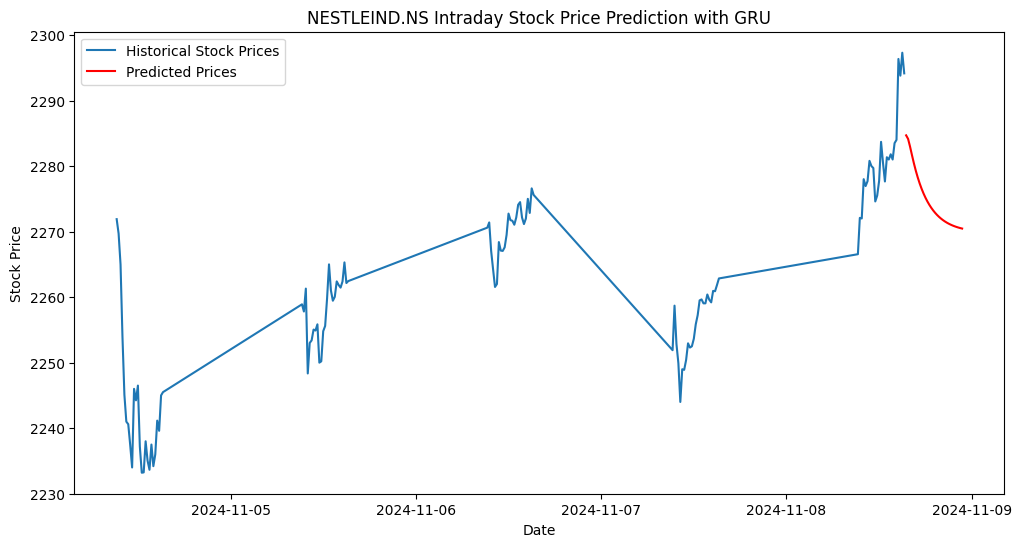

Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'


In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Fetch Intraday Stock Data
ticker_symbol = "NESTLEIND.NS"
stock_data = yf.Ticker(ticker_symbol).history(interval="15m", period="5d")['Close']

# Step 2: Prepare Stock Data for GRU Model
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

# Step 3: Create Dataset for GRU Model
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 intervals (15-minute intervals in this case) for prediction
X, y = create_dataset(stock_data_scaled, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 4: Define GRU Model for Time Series Prediction
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

# Step 6: Predict Next 15-Minute Intervals
last_60_intervals = stock_data_scaled[-time_step:].reshape(1, time_step, 1)
predicted_prices = []

for _ in range(30):  # Predict the next 30 intervals (roughly 7.5 hours for 15-min intervals)
    prediction = model.predict(last_60_intervals, verbose=0)

    # Append the predicted value to the rolling window
    predicted_prices.append(prediction[0, 0])

    # Update input with prediction for rolling prediction
    # Reshape prediction to be a 3D array and concatenate
    prediction_reshaped = prediction.reshape(1, 1, 1)  # Ensure the shape is (1, 1, 1)
    last_60_intervals = np.append(last_60_intervals[:, 1:, :], prediction_reshaped, axis=1)

# Inverse transform predicted prices back to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))


# Step 7: Join Last Actual Price with First Predicted Price
last_actual_price = stock_data.iloc[-1]  # Last actual price
combined_prices = np.concatenate(([[last_actual_price]], predicted_prices), axis=0)


# Step 8: Plot Predictions
future_dates = [stock_data.index[-1] + timedelta(minutes=15 * i) for i in range(1, 31)]
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data.values, label='Historical Stock Prices')
plt.plot(future_dates, combined_prices[1:], label='Predicted Prices', color='red')  # Skip the first actual value in the plot
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker_symbol} Intraday Stock Price Prediction with GRU')
plt.legend()
plt.show()

import numpy as np

# Convert the predictions to a NumPy array
predicted_array = np.array(predicted_prices.flatten())

# Save the array to a .npy file
np.save("nestle_stock_predictions_with_knowledge_graph.npy", predicted_array)

print("Predictions saved to 'nestle_stock_predictions_with_knowledge_graph.npy'")

# Performance comparision with and without KG

<ipython-input-34-84617d497af4>:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



+----+--------+------------------------+---------------------------+-------------------------------+
|    |   Time |   With Knowledge Graph |   Without Knowledge Graph |   Difference (With - Without) |
+====+========+========================+===========================+===============================+
|  0 |      0 |                2361.07 |                   2284.69 |                       76.3838 |
+----+--------+------------------------+---------------------------+-------------------------------+
|  1 |      1 |                2374.38 |                   2284.15 |                       90.2339 |
+----+--------+------------------------+---------------------------+-------------------------------+
|  2 |      2 |                2390.83 |                   2282.99 |                      107.837  |
+----+--------+------------------------+---------------------------+-------------------------------+
|  3 |      3 |                2407.77 |                   2281.69 |                      1

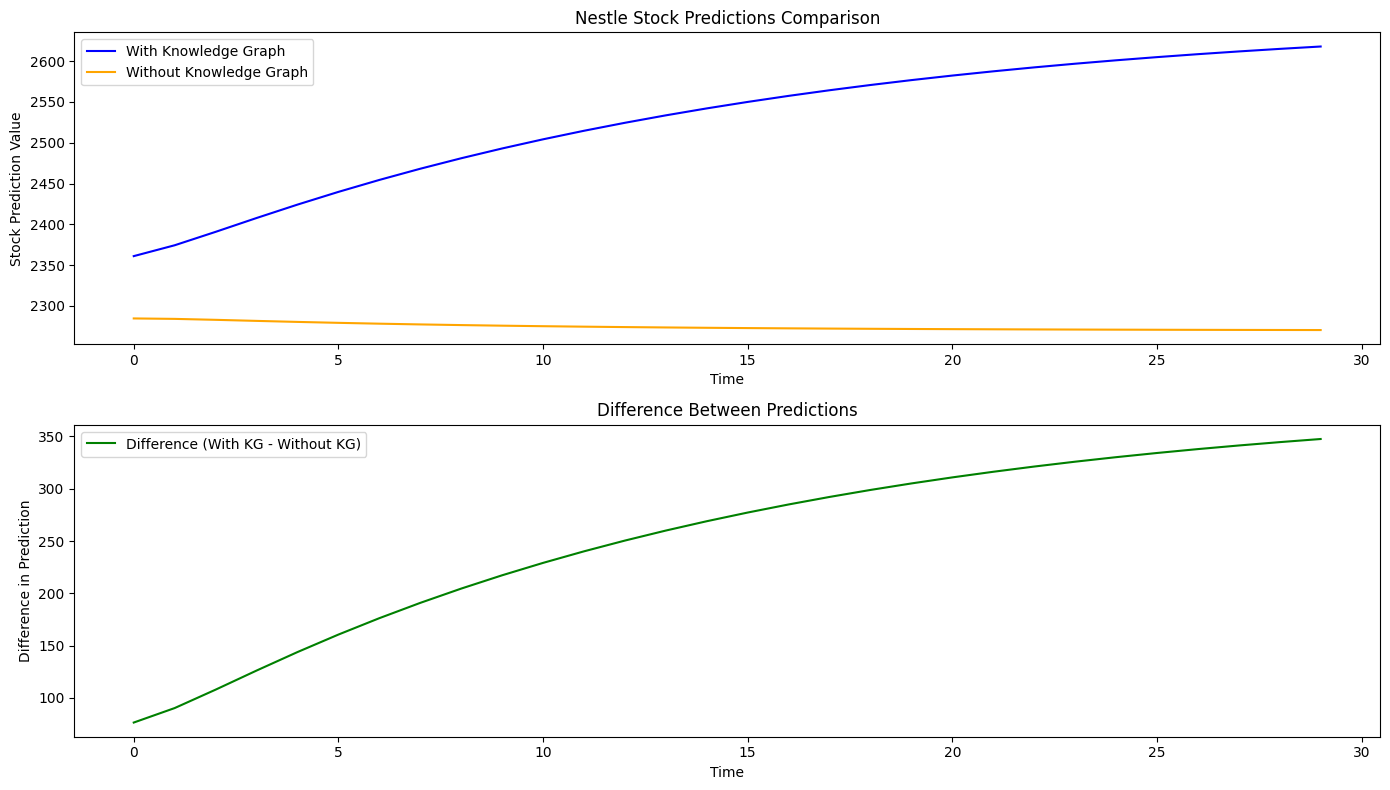

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from tabulate import tabulate

# Load the prediction data from .npy files in the sample_data directory
pred_with_kg = np.load("/content/nestle_stock_predictions1.npy")
pred_without_kg = np.load("/content/nestle_stock_predictions_with_knowledge_graph.npy")

# Calculate the difference between the two sets of predictions
difference = pred_with_kg - pred_without_kg

# Calculate error metrics
mae = mean_absolute_error(pred_without_kg, pred_with_kg)
mse = mean_squared_error(pred_without_kg, pred_with_kg)

# Create a DataFrame for the predictions and error metrics
metrics_df = pd.DataFrame({
    'Time': range(len(pred_with_kg)),
    'With Knowledge Graph': pred_with_kg,
    'Without Knowledge Graph': pred_without_kg,
    'Difference (With - Without)': difference
})

# Add a row for the error metrics at the end of the table
error_metrics_row = pd.DataFrame({
    'Time': ['Error Metrics'],
    'With Knowledge Graph': [mae],
    'Without Knowledge Graph': [mse],
    'Difference (With - Without)': [None]
})

# Append error metrics row to the DataFrame
metrics_df = pd.concat([metrics_df, error_metrics_row], ignore_index=True)

# Display the first 5 rows of the table using tabulate
def display_table(data):
    print(tabulate(data[0:30], headers='keys', tablefmt='grid', showindex=True))

# Display the table
display_table(metrics_df)

# Plot the predictions and the differences
plt.figure(figsize=(14, 8))

# Subplot 1: Plot of both predictions
plt.subplot(2, 1, 1)
plt.plot(pred_with_kg, label='With Knowledge Graph', color='blue')
plt.plot(pred_without_kg, label='Without Knowledge Graph', color='orange')
plt.title('Nestle Stock Predictions Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Prediction Value')
plt.legend()

# Subplot 2: Plot of differences
plt.subplot(2, 1, 2)
plt.plot(difference, label='Difference (With KG - Without KG)', color='green')
plt.title('Difference Between Predictions')
plt.xlabel('Time')
plt.ylabel('Difference in Prediction')
plt.legend()

plt.tight_layout()
plt.show()

# Performance comparision between LSTM and GRU

<ipython-input-40-6d1fc98faf09>:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



+----+--------+------------+-------------+-------------------------------+
|    |   Time |   With GRU |   With LSTM |   Difference (With - Without) |
+====+========+============+=============+===============================+
|  0 |      0 |    2361.07 |     2347.82 |                       13.2522 |
+----+--------+------------+-------------+-------------------------------+
|  1 |      1 |    2374.38 |     2346.6  |                       27.7837 |
+----+--------+------------+-------------+-------------------------------+
|  2 |      2 |    2390.83 |     2347.25 |                       43.5781 |
+----+--------+------------+-------------+-------------------------------+
|  3 |      3 |    2407.77 |     2349.13 |                       58.646  |
+----+--------+------------+-------------+-------------------------------+
|  4 |      4 |    2424.21 |     2351.79 |                       72.4238 |
+----+--------+------------+-------------+-------------------------------+
|  5 |      5 |    2439.8

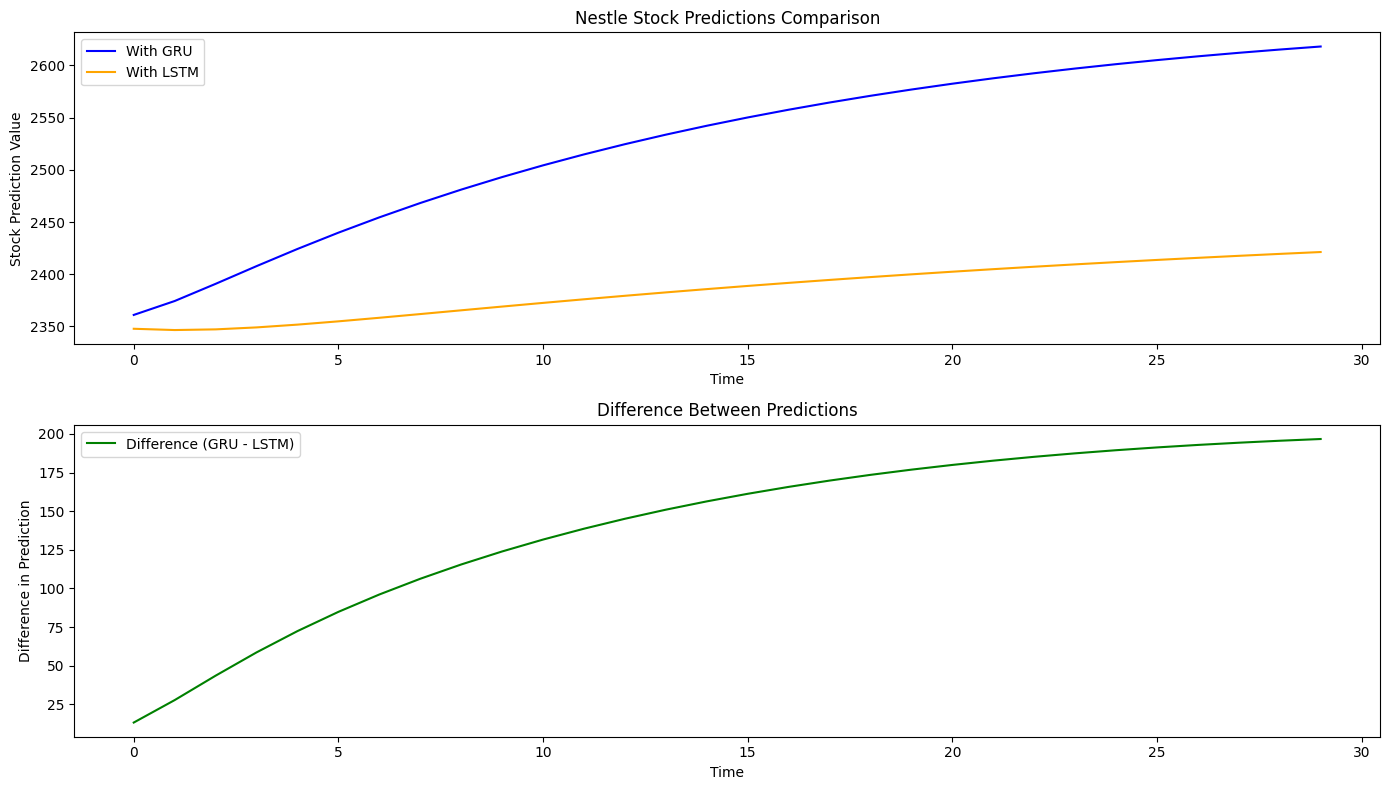

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from tabulate import tabulate

# Load the prediction data from .npy files in the sample_data directory
pred_with_kg = np.load("/content/nestle_stock_predictions1.npy")
pred_without_kg = np.load("/content/nestle_stock_predictions2.npy")

# Calculate the difference between the two sets of predictions
difference = pred_with_kg - pred_without_kg

# Calculate error metrics
mae = mean_absolute_error(pred_without_kg, pred_with_kg)
mse = mean_squared_error(pred_without_kg, pred_with_kg)

# Create a DataFrame for the predictions and error metrics
metrics_df = pd.DataFrame({
    'Time': range(len(pred_with_kg)),
    'With GRU': pred_with_kg,
    'With LSTM': pred_without_kg,
    'Difference (With - Without)': difference
})

# Add a row for the error metrics at the end of the table
error_metrics_row = pd.DataFrame({
    'Time': ['Error Metrics'],
    'With GRU': [mae],
    'With LSTM': [mse],
    'Difference (With - Without)': [None]
})

# Append error metrics row to the DataFrame
metrics_df = pd.concat([metrics_df, error_metrics_row], ignore_index=True)

# Display the first 5 rows of the table using tabulate
def display_table(data):
    print(tabulate(data[0:30], headers='keys', tablefmt='grid', showindex=True))

# Display the table
display_table(metrics_df)

# Plot the predictions and the differences
plt.figure(figsize=(14, 8))

# Subplot 1: Plot of both predictions
plt.subplot(2, 1, 1)
plt.plot(pred_with_kg, label='With GRU', color='blue')
plt.plot(pred_without_kg, label='With LSTM', color='orange')
plt.title('Nestle Stock Predictions Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Prediction Value')
plt.legend()

# Subplot 2: Plot of differences
plt.subplot(2, 1, 2)
plt.plot(difference, label='Difference (GRU - LSTM)', color='green')
plt.title('Difference Between Predictions')
plt.xlabel('Time')
plt.ylabel('Difference in Prediction')
plt.legend()

plt.tight_layout()
plt.show()